Team name: Spencer Boat

In [ ]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_train.csv', 
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_test.csv', 
          'edx_test.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import graphviz
from sklearn import tree

In [ ]:
train = pd.read_csv('edx_train.csv')
train[['school','course_id','quarter']] = train['course_id'].str.split(pat='/', expand=True)
train = train.drop(columns=['userid_DI','start_time_DI','last_event_DI','quarter', 'gender'])
train['grade'] = pd.to_numeric(train['grade'], errors='coerce')
train = pd.get_dummies(train)
train = train.fillna(-1)

test = pd.read_csv('edx_test.csv')
test[['school','course_id','quarter']] = test['course_id'].str.split(pat='/', expand=True)
test['grade'] = pd.to_numeric(test['grade'], errors='coerce')
test = pd.get_dummies(test)
test = test.fillna(-1)

target = 'certified'
features = list(train.columns)
features.remove('certified')

train

,registered,viewed,explored,certified,YoB,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts,course_id_CB22x,course_id_CS50x,course_id_ER22x,course_id_PH207x,course_id_PH278x,final_cc_cname_DI_Australia,final_cc_cname_DI_Bangladesh,final_cc_cname_DI_Brazil,final_cc_cname_DI_Canada,final_cc_cname_DI_China,final_cc_cname_DI_Colombia,final_cc_cname_DI_Egypt,final_cc_cname_DI_France,final_cc_cname_DI_Germany,final_cc_cname_DI_Greece,final_cc_cname_DI_India,final_cc_cname_DI_Indonesia,final_cc_cname_DI_Japan,final_cc_cname_DI_Mexico,final_cc_cname_DI_Morocco,final_cc_cname_DI_Nigeria,final_cc_cname_DI_Other Africa,final_cc_cname_DI_Other East Asia,final_cc_cname_DI_Other Europe,final_cc_cname_DI_Other Middle East/Central Asia,"final_cc_cname_DI_Other North & Central Amer., Caribbean",final_cc_cname_DI_Other Oceania,final_cc_cname_DI_Other South America,final_cc_cname_DI_Other South Asia,final_cc_cname_DI_Pakistan,final_cc_cname_DI_Philippines,final_cc_cname_DI_Poland,final_cc_cname_DI_Portugal,final_cc_cname_DI_Russian Federation,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,school_HarvardX
0,1,1,1,1,1984.0,1.00,1161.0,50.0,-1.0,12.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
1,1,1,1,1,1985.0,0.85,1360.0,10.0,-1.0,29.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
2,1,1,1,1,-1.0,1.00,77.0,18.0,-1.0,7.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1982.0,0.85,1425.0,29.0,-1.0,34.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,1,1,0,0,1989.0,0.00,6.0,1.0,-1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,1,0,0,0,1992.0,0.00,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
8754,1,1,1,1,1972.0,1.00,1962.0,16.0,112.0,13.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
8755,1,0,0,0,1973.0,0.00,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
8756,1,1,1,1,1981.0,0.99,1110.0,23.0,-1.0,32.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


Here, I am pre-processing the data for use on a Decision Tree and Random Forest model. I split the `course_id` column into three columns in order for the model to use the specific school and class in its predictions. I also replaced categorical variables with dummies, which revealed to me that the dataset only contains Harvard courses and not any MIT courses. I also chose to fill NaN values with `-1` with the hope that it would not confuse the model too much. I also removed `userid_DI` and the dated columns because those did not seem useful in making predictions for the future.

**Ethical Considerations** I removed gender from the analyzed features, which I later found made the Random Forest Model less accurate but had no effect on the Decision Tree Model. The model must have been on the Pareto Frontier, and considering gender in the model in no way seems "fair" to me. I chose to include country of origin for the students even if that may create biases against certain countries. In this situation, I figured it would be a relevant factor to analyze in this model because it was stated that part of the goal was to find countries that the online education platform should invest more time and resources into servicing. In the end, this may create a feedback loop where people from those countries are the only ones catered to or allowed to take the program.

In [ ]:
train, validation = train_test_split(train, test_size=0.2)

In [ ]:
# Classifier 1 - Majority Classifier (source: myself, homework 5)
maj_class = train[target].mode().item()
correct = 0
total_validation = len(validation)
total_train = len(train)
for row in validation[target]:
    if maj_class == row:
        correct = correct + 1
majority_classifier_validation_accuracy = correct / total_validation
correct = 0
for row in train[target]:
    if maj_class == row:
        correct = correct + 1

majority_classifier_train_accuracy = correct / total_train
majority_classifier_validation_accuracy

0.5622146118721462

My first model was a Majority Classifier. This found that most students did not get the certification and would predict that any student would also not get certified. Quite pessimistic! It was a little better than random guessing when tested against the validation set, though.

In [ ]:
# Classifier 2 - Random Forest (source: homework 5)
import scipy.stats 

class RandomForest: 
    def __init__(self, num_trees, max_depth=None):
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1) 
            for i in range(num_trees)
        ]
        
    def fit(self, X, y):  
        for i, tree in enumerate(self._trees):
            random_ind = np.random.randint(len(X), size=len(X))
            train = X.iloc[random_ind]
            target = y.iloc[random_ind]
            tree.fit(train, target)
        
            
    def predict(self, X):
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            preds = tree.predict(X)
            predictions[:, i] = preds
        return scipy.stats.mode(predictions, axis=1)[0]

Here I used the `RandomForest` class mostly defined in Homework 5 to make a `RandomForest` model of depth `10` with `50` trees.

In [ ]:
rf = RandomForest(50, max_depth=10)
rf.fit(train[features], train[target])
rf.predict(validation[features])

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [ ]:
#Classifier 3 - Decision Tree
tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = tree_model.fit(train[features], train[target])

Here, I made a simpler `DecisionTree` model of depth `6` to test against the `RandomForest` model.

Depth 1
Depth 3
Depth 5
Depth 7
Depth 9
Depth 11
Depth 13
Depth 15
Depth 17
Depth 19
Depth 21
Depth 23
Depth 25


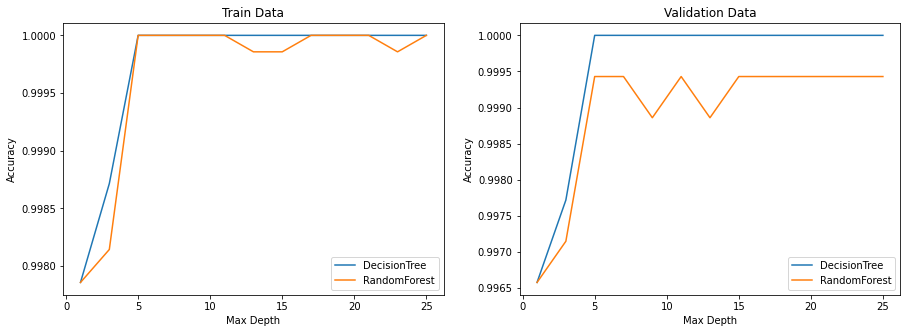

In [ ]:
#Plot (source: homework 5)
depths = list(range(1, 26, 2))
dt_accuracies = []
rf_accuracies = []

for i in depths:
    print(f'Depth {i}')

    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train[features], train[target])
    dt_accuracies.append((
        accuracy_score(tree.predict(train[features]), train[target]),
        accuracy_score(tree.predict(validation[features]), validation[target])
    ))

    rf = RandomForest(15, max_depth=i)
    rf.fit(train[features], train[target])
    rf_accuracies.append((     
        accuracy_score(rf.predict(train[features]), train[target]),
        accuracy_score(rf.predict(validation[features]), validation[target])
    ))
    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='DecisionTree')
axs[0].plot(depths, [acc[0] for acc in rf_accuracies], label='RandomForest')

axs[1].plot(depths, [acc[1] for acc in dt_accuracies], label='DecisionTree')
axs[1].plot(depths, [acc[1] for acc in rf_accuracies], label='RandomForest')

axs[0].set_title('Train Data')
axs[1].set_title('Validation Data')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')

My inital assumption (and submission) was that the `RandomForest` model would be best. Upon looking at this graph (which was also borrowed from the provided code in Homework 5), it shows that the `DecisionTree` model is consistently better at predicting the validation data past a certain depth of tree. I tried a few different amounts of trees in the forest, and they all yielded the same results.

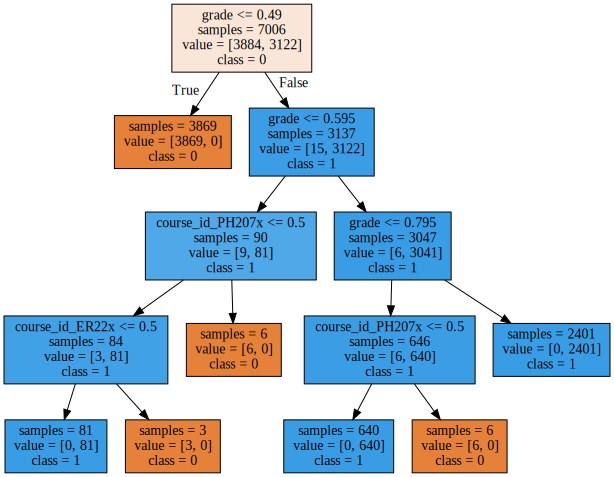

In [ ]:
# Displaying the Tree (source: Homework 5)
def draw_tree(tree_model, features):
    """
    visualizes a Decision Tree
    """
    tree_data = tree.export_graphviz(tree_model, 
                                    impurity=False, 
                                    feature_names=features,
                                    class_names=tree_model.classes_.astype(str),
                                    filled=True,
                                    out_file=None)
    graph = graphviz.Source(tree_data) 
    display(graph)

draw_tree(decision_tree_model, features)

This tree visualization shows the factors that lead into predicting the success of students in the course. Grade was obviously a huge factor that predicted whether a person would get certified in the class. The other huge predictor was which class was being taken. Using those two features accurately sorted everyone into a proper class on the training, validation, and test data. This shows that, if anything, my model is biased against the grading cutoff for passing certain classes. This particular model, however, would not perform for the purpose of telling the institution which types people they should be targeting to take the class. That is something I am going to continue to explore with this data after I submit this assignment. For now, why mess with perfection?

In [ ]:
#Test prediction (using DecisionTree model)
test_prediction = decision_tree_model.predict(test[features])
output_test = pd.read_csv('edx_test.csv')
to_save = output_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = test_prediction.astype(np.int32) #thanks, Kenny Le on the discussion board!
to_save.to_csv('submission.csv', index=False)

Here, I had to reimport the test data to bring back the `user_id` field for formatting the output.